In [1]:
import sys
print(sys.version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue import Sheet, SheetGeometry, Monolayer, config, MonoLayerGeometry
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.draw import sheet_view
from tyssue.io import hdf5

from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.dynamics import model_factory, effectors

from tyssue import collisions
from tyssue.collisions.solvers import CollisionSolver
from tyssue import version
print('tyssue version: ', version.full_version)


3.7.1 | packaged by conda-forge | (default, Nov 13 2018, 18:15:35) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
tyssue version:  0.2.4.dev0+6ea6008


In [2]:
from tyssue import stores

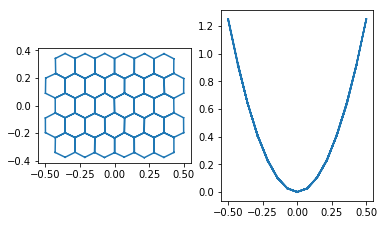

In [3]:

sheet = Sheet('crossed', hdf5.load_datasets("/home/guillaume/Dev/tyssue/tyssue/stores/sheet6x5.hf5"))

sheet.vert_df.z = 5 * sheet.vert_df.x**2
sheet.vert_df[sheet.coords] += np.random.normal(scale=0.001, size=(sheet.Nv, 3))
    

SheetGeometry.update_all(sheet)


fig, axes = plt.subplots(1, 2, sharex=True)
fig, ax = sheet_view(sheet, coords=['x', 'y'], mode='quick', ax=axes[0])
fig, ax = sheet_view(sheet, coords=['x', 'z'], mode='quick', ax=axes[1])



In [9]:
from numbers import Number, Real
isinstance(1, Real)

True

In [4]:
positions_buffer = sheet.vert_df[sheet.coords].copy()

sheet.vert_df.x -=  35*(sheet.vert_df.x/2)**3
SheetGeometry.update_all(sheet)

ipv.clear()
fig, mesh = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

## Better collision avoidance

Inspired by this paper:

Liu, J.-D., Ko, M.-T., & Chang, R.-C. (1998). _A simple self-collision avoidance for cloth animation_. Computers & Graphics, 22(1), 117–128. [DOI](https://doi.org/doi:10.1016/s0097-8493(97)00087-3)


In [5]:
class CollidingBoxes:
    
    def __init__(self, sheet, position_buffer, colliding_edges):
        self.sheet = sheet
        self.edge_pairs = colliding_edges
        self.face_pairs = self._get_intersecting_faces()
        self.edge_buffer = sheet.upcast_srce(positions_buffer).copy()
        self.edge_buffer.columns = ['sx', 'sy', 'sz']
        
    def _get_intersecting_faces(self):
        """Returns unique pairs of intersecting faces 
        
        """
        _face_pairs = self.sheet.edge_df.loc[
            self.edge_pairs.flatten(), 'face'].values.reshape((-1, 2))
        return np.array([[f0, f1] for f0, f1 in set(map(frozenset, _face_pairs))])
 
    
    def get_limits(self, shyness=1e-10):
        
        for face_pair in self.face_pairs:
            yield self._collision_plane(face_pair, shyness)

    def solve_collisions(self, shyness=1e-10):
        
        colliding_verts = self.sheet.edge_df[
            sheet.edge_df["face"].isin(self.face_pairs.ravel())]['srce']
        upper_bounds = pd.DataFrame(
            index=pd.Index(colliding_verts, 'srce'),
            columns=sheet.coords)
        upper_bounds[:] = np.inf
        lower_bounds = pd.DataFrame(
            index=pd.Index(colliding_verts, 'srce'),
            columns=sheet.coords)
        lower_bounds[:] = -np.inf

        for lower, upper in self.get_limits(shyness):
            
            sub_lower = lower_bounds.loc[lower.index, lower.columns]
            lower_bounds.loc[lower.index, lower.columns] = pd.concat(
                (sub_lower, lower), axis=1).max(axis=1)

            sub_upper = upper_bounds.loc[upper.index, upper.columns]
            upper_bounds.loc[upper.index, upper.columns] = pd.concat(
                (sub_upper, upper), axis=1).min(axis=1)

        self.sheet.vert_df.x = pd.concat(
            (lower_bounds.x, sheet.vert_df.x), axis=1).max(axis=1)
        self.sheet.vert_df.x = pd.concat(
            (upper_bounds.x, sheet.vert_df.x), axis=1).min(axis=1)
        
    def _collision_plane(self, face_pair, shyness):

        f0, f1 = face_pair

        fe0c = self.sheet.edge_df[sheet.edge_df['face'] == f0].copy()
        fe1c = self.sheet.edge_df[sheet.edge_df['face'] == f1].copy()

        fe0p = self.edge_buffer[sheet.edge_df['face'] == f0].copy()
        fe1p = self.edge_buffer[sheet.edge_df['face'] == f1].copy()

        bb0c = face_bbox(fe0c)
        bb1c = face_bbox(fe1c)

        bb0p = face_bbox(fe0p)
        bb1p = face_bbox(fe1p)

        dr0 = (bb0c - bb0p)
        dr1 = (bb1c - bb1p)

        sign_change_l1h0 = np.sign((bb1c.l - bb0c.h)*(bb1p.l - bb0p.h)) < 0
        sign_change_l0h1 = np.sign((bb0c.l - bb1c.h)*(bb0p.l - bb1p.h)) < 0

        # face 0 is to the left of face 0 on the collision axis
        if any(sign_change_l1h0):
            lower_bound = pd.DataFrame(index=fe1c.srce)
            upper_bound = pd.DataFrame(index=fe0c.srce)
            
            coll_ax = bb0c[sign_change_l1h0].index
            plane_coords = (
                (bb0p.h*dr1.l - bb1p.l*dr0.h)
                /(dr1.l - dr0.h)).loc[coll_ax]

        # face 0 is to the right of face 1 on the collision axis
        elif any(sign_change_l0h1):
            lower_bound = pd.DataFrame(index=fe0c.srce)
            upper_bound = pd.DataFrame(index=fe1c.srce)
            coll_ax = bb0c[sign_change_l0h1].index
            plane_coords = (
                (bb1p.h*dr0.l - bb0p.l*dr1.h)
                /(dr0.l - dr1.h)).loc[coll_ax]
        else:
            raise ValueError("No collision detected")

        for c in coll_ax:
            lower_bound[c] = plane_coords.loc[c] + shyness/2
            upper_bound[c] = plane_coords.loc[c] - shyness/2
            return lower_bound, upper_bound
            

def face_bbox(face_edges):
    points = face_edges[['sx', 'sy', 'sz']].values
    lower = points.min(axis=0)
    upper = points.max(axis=0)
    return pd.DataFrame([lower, upper], index=list('lh'),
                        columns=list('xyz'),
                        dtype=np.float).T

        
def get_cube(bbox):
    
    triangles = np.array(
        [[0, 1, 4],
         [5, 1, 4],
         [0, 2, 4],
         [6, 2, 4],
         [0, 2, 1],
         [3, 2, 1],
         [7, 5, 6],
         [4, 5, 6],
         [7, 3, 6],
         [2, 3, 6],
         [5, 7, 1],
         [3, 7, 1]]
    )
    grid = np.meshgrid([0, 1], [0, 1], [0, 1])
    xx, yy, zz = (b.take(u.ravel()) for b, u in zip(bbox, grid))
    
    return {'x': xx, 'y': yy, 'z': zz, 'triangles': triangles}


In [6]:
colliding_edges = collisions.self_intersections(sheet)

In [7]:
colliding_edges

array([[35,  9],
       [34,  9],
       [ 1, 32]])

In [9]:
colliding_edges = collisions.self_intersections(sheet)
boxes = CollidingBoxes(sheet, positions_buffer, colliding_edges)
boxes.solve_collisions(shyness=0.01)


In [14]:
sheet.vert_df.loc[[12, 22], 'x'].diff().loc[22]

-0.01

In [10]:
for lim in boxes.get_limits(0.1):
    print(lim)

(             x
srce          
12    0.050808
42    0.050808
43    0.050808
13    0.050808
16    0.050808
15    0.050808,              x
srce          
22   -0.049192
10   -0.049192
23   -0.049192
72   -0.049192
71   -0.049192
37   -0.049192)
(             x
srce          
3     0.049036
2     0.049036
14    0.049036
4     0.049036
52    0.049036
50    0.049036,              x
srce          
34   -0.050964
40   -0.050964
64   -0.050964
74   -0.050964
39   -0.050964
75   -0.050964)


In [33]:
ipv.clear()
sheet_view(sheet, mode='3D')
ipv.squarelim()
ipv.show()

In [13]:
colliding_verts = boxes.colliding_verts

In [14]:
upper_bounds = pd.DataFrame(
    index=pd.Index(colliding_verts, 'srce'),
    columns=sheet.coords)
upper_bounds[:] = np.inf
lower_bounds = pd.DataFrame(
    index=pd.Index(colliding_verts, 'srce'),
    columns=sheet.coords)
lower_bounds[:] = -np.inf


for lower, upper in boxes.get_limits():
    sub_lower = lower_bounds.loc[lower.index, lower.columns]
    lower_bounds.loc[lower.index, lower.columns] = pd.concat(
        (sub_lower, lower), axis=1).max(axis=1)

    sub_upper = upper_bounds.loc[upper.index, upper.columns]
    upper_bounds.loc[upper.index, upper.columns] = pd.concat(
        (sub_upper, upper), axis=1).min(axis=1)

    
sheet.vert_df.x = pd.concat((lower_bounds.x, sheet.vert_df.x), axis=1).max(axis=1)
sheet.vert_df.x = pd.concat((upper_bounds.x, sheet.vert_df.x), axis=1).min(axis=1)
    

In [15]:
ipv.clear()
sheet_view(sheet, mode='3D')
ipv.squarelim()
ipv.show()

In [224]:
def get_cube(bbox):
    
    triangles = np.array(
        [[0, 1, 4],
         [5, 1, 4],
         [0, 2, 4],
         [6, 2, 4],
         [0, 2, 1],
         [3, 2, 1],
         [7, 5, 6],
         [4, 5, 6],
         [7, 3, 6],
         [2, 3, 6],
         [5, 7, 1],
         [3, 7, 1]]
    )
    grid = np.meshgrid([0, 1], [0, 1], [0, 1])
    xx, yy, zz = (b.take(u.ravel()) for b, u in zip(bbox, grid))
    
    return {'x': xx, 'y': yy, 'z': zz, 'triangles': triangles}

    

In [225]:
face_pairs = boxes.face_pairs
edge_buffer = boxes.edge_buffer

TraitError: Element of the 'matrix_world' trait of a Figure instance must be a float, but a value of None <class 'NoneType'> was specified.

In [226]:
p = 0

f0 = face_pairs[p, 0]
fe0 = sheet.edge_df[sheet.edge_df['face'] == f0]
bb0 = face_bbox(fe0)
cube0 = get_cube(bb0.values)

f1 = face_pairs[p, 1]
fe1 = sheet.edge_df[sheet.edge_df['face'] == f1]
bb1 = face_bbox(fe1)
cube1 = get_cube(bb1.values)

f0p = face_pairs[p, 0]
fe0p = edge_buffer[sheet.edge_df['face'] == f0]
bb0p = face_bbox(fe0p)
cube0p = get_cube(bb0p.values)

f1p = face_pairs[p, 1]
fe1p = edge_buffer[sheet.edge_df['face'] == f1]
bb1p = face_bbox(fe1p)
cube1p = get_cube(bb1p.values)



ipv.clear()
sheet_view(sheet, mode='3D')
ipv.squarelim()
ipv.plot_trisurf(**cube0, color='#0eaa0e')
ipv.plot_trisurf(**cube1, color='#aa0eaa')

ipv.plot_trisurf(**cube0p, color='#aaeeaa')
ipv.plot_trisurf(**cube1p, color='#eeaaee')

ipv.show()


(0, 2)

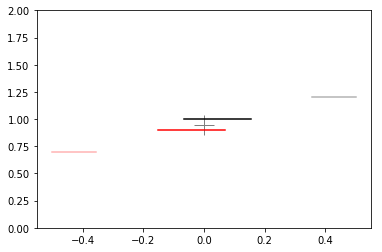

In [127]:
fig, ax = plt.subplots()
l0s = list(boxes.get_limits())[0]
ax.plot(l0s.min_x.iloc[0], 0.95, 'k+', ms=20, alpha=0.5)

ax.plot(bb0.loc['x'].values, [1, 1], 'k')
ax.plot(bb0p.loc['x'].values, [1.2, 1.2], 'k', alpha=0.3)

ax.plot(bb1.loc['x'].values, [0.9, 0.9], 'r')
ax.plot(bb1p.loc['x'].values, [0.7, 0.7], 'r', alpha=0.3)

ax.set_ylim(0, 2)

#### Here we know the collision happend along the $x$ axis 

In [131]:

min(np.inf, 10)

10

In [216]:
ipv.clear()
sheet_view(sheet, mode='3D')
ipv.squarelim()

ipv.show()


TraitError: Element of the 'matrix_world' trait of a Figure instance must be a float, but a value of None <class 'NoneType'> was specified.

In [147]:
collisions.self_intersections(sheet)

array([], shape=(0, 2), dtype=int64)